In [41]:
# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [56]:
# Read the csv file
df = pd.read_csv('/content/drive/MyDrive/Datasets/Project/ZOMATO.NS.csv')
print(df.head())

         Date       Open       High        Low      Close  Adj Close    Volume
0  2023-04-10  52.150002  54.200001  51.799999  53.950001  53.950001  60655412
1  2023-04-11  54.650002  55.250000  53.250000  53.950001  53.950001  41101417
2  2023-04-12  54.250000  54.250000  52.900002  53.200001  53.200001  30848068
3  2023-04-13  53.200001  54.150002  52.849998  53.849998  53.849998  26646279
4  2023-04-17  54.200001  54.250000  53.000000  53.950001  53.950001  24787918


In [43]:
# Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates.

230   2024-03-14
231   2024-03-15
232   2024-03-18
233   2024-03-19
234   2024-03-20
235   2024-03-21
236   2024-03-22
237   2024-03-26
238   2024-03-27
239   2024-03-28
240   2024-04-01
241   2024-04-02
242   2024-04-03
243   2024-04-04
244   2024-04-05
Name: Date, dtype: datetime64[ns]


In [44]:
# Isolate variables for training
cols = list(df)[1:6]
print(cols)

['Open', 'High', 'Low', 'Close', 'Adj Close']


<Axes: >

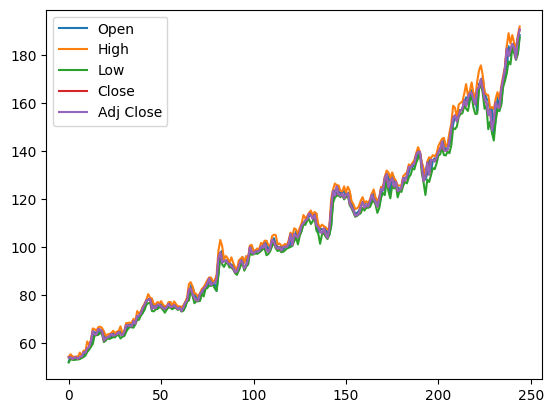

In [45]:
# New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

df_for_plot=df_for_training.tail(250)
df_for_plot.plot.line()

In [57]:
# Scaling data
scaler = MinMaxScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

print(df_for_training_scaled)

[[0.00000000e+00 3.63232834e-04 0.00000000e+00 5.46249094e-03
  5.46249094e-03]
 [1.83688467e-02 7.99126765e-03 1.07050645e-02 5.46249094e-03
  5.46249094e-03]
 [1.54298165e-02 7.26465669e-04 8.12109998e-03 0.00000000e+00
  0.00000000e+00]
 ...
 [9.53710484e-01 9.28804919e-01 9.30601743e-01 9.11143503e-01
  9.11143503e-01]
 [9.43056575e-01 9.73483407e-01 9.48320414e-01 9.74508376e-01
  9.74508376e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00]]


In [47]:
# Empty lists to be populated with formatted training data
trainX = []
trainY = []

In [48]:
# Creating sequences
n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (231, 14, 5).
trainY shape == (231, 1).


In [49]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/5
13/13 [==============================] - 5s 85ms/step - loss: 0.1111 - val_loss: 0.0120
Epoch 2/5
13/13 [==============================] - 0s 19ms/step - loss: 0.0127 - val_loss: 0.0090
Epoch 3/5
13/13 [==============================] - 0s 17ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 4/5
13/13 [==============================] - 0s 17ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 5/5
13/13 [==============================] - 0s 17ms/step - loss: 0.0056 - val_loss: 0.0089


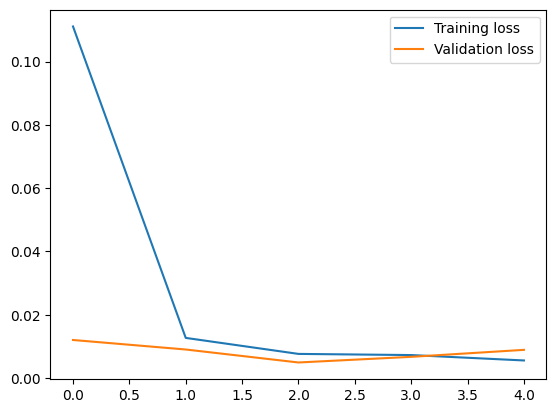

In [50]:
# Fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [51]:
# To account for holidays like weekends (couldn't find one for India)
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 16
n_days_for_prediction=30
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()

In [52]:
# Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

1/1 [==============================] - 0s 311ms/step


In [53]:
# Perform inverse transformation
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

In [54]:
# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

<ipython-input-55-0970a6ec7485>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


<Axes: xlabel='Date', ylabel='Open'>

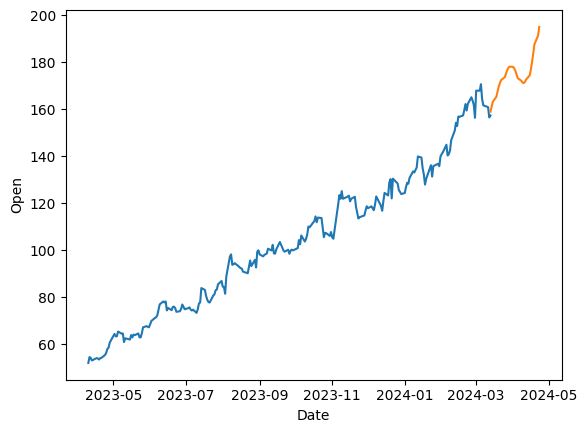

In [55]:
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2023-4-10']

# Plot the dataframes using separate x and y values
original = original.iloc[:-15]

sns.lineplot(data=original, x="Date", y="Open")
sns.lineplot(data=df_forecast, x="Date", y="Open")